### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [94]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
110,NSW111,1,20,9,1,0,0,1,6083.9940,0.000,8881.6650
384,PSID200,0,31,6,0,0,0,1,2666.5620,1321.258,0.0000
482,PSID298,0,47,9,0,0,1,1,25862.3200,0.000,25564.6700
232,PSID48,0,25,12,1,0,1,0,295.8493,6942.871,461.0507
228,PSID44,0,21,12,0,0,1,0,13601.2300,7202.468,10746.0300
553,PSID369,0,16,8,0,0,0,1,0.0000,0.000,0.0000
503,PSID319,0,20,9,0,0,1,1,5229.2830,0.000,15892.9500
577,PSID393,0,38,12,0,0,1,0,0.0000,0.000,18756.7800
344,PSID160,0,25,14,0,1,1,0,1622.2730,2239.694,1892.9680
213,PSID29,0,21,9,0,0,1,1,11156.0700,8441.371,1213.2140


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [17]:
treated = df[df["treat"] == 1]
control = df[df["treat"] == 0]

In [18]:
treated[['re74', 're75', 're78']].describe()

,re74,re75,re78
count,185.000000,185.000000,185.000000
mean,2095.573689,1532.055314,6349.143530
std,4886.620353,3219.250870,7867.402218
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,485.229800
50%,0.000000,0.000000,4232.309000
75%,1291.468000,1817.284000,9642.999000
max,35040.070000,25142.240000,60307.930000


In [19]:
control[['re74', 're75', 're78']].describe()

,re74,re75,re78
count,429.000000,429.000000,429.000000
mean,5619.236506,2466.484443,6984.169742
std,6788.750796,3291.996183,7294.161791
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,220.181300
50%,2547.047000,1086.726000,4975.505000
75%,9277.128000,3881.419000,11688.820000
max,25862.320000,18347.230000,25564.670000


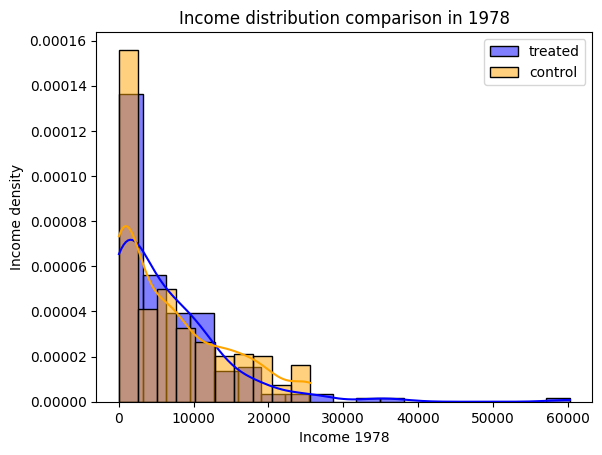

In [25]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

<Figure size 1500x200 with 0 Axes>

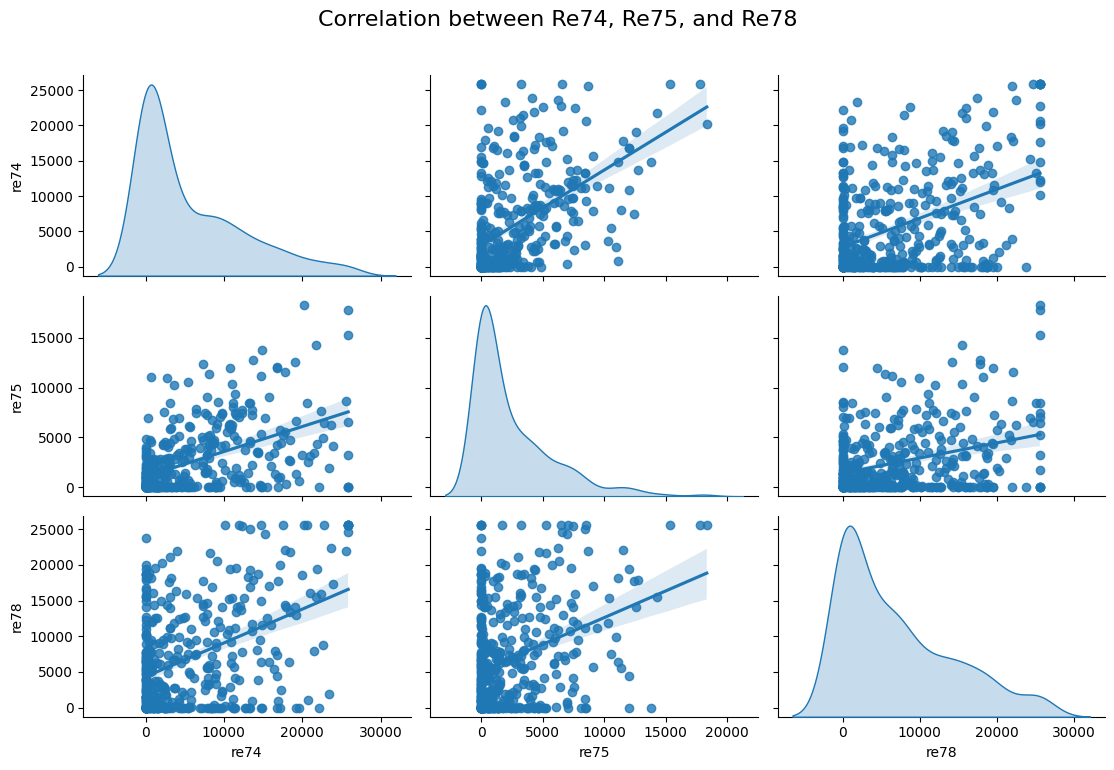

In [21]:
df_corr = control[['re74', 're75', 're78']]

# Pairplot with specific pairings
plt.figure(figsize=(15, 2))
g = sns.pairplot(df_corr, kind='reg', diag_kind='kde', height=2.5, aspect=1.5)
g.fig.suptitle("Correlation between Re74, Re75, and Re78", y=1.02, fontsize=16)
# plt.title("Eraning between years before and after treatment")
plt.tight_layout()

<Figure size 1500x200 with 0 Axes>

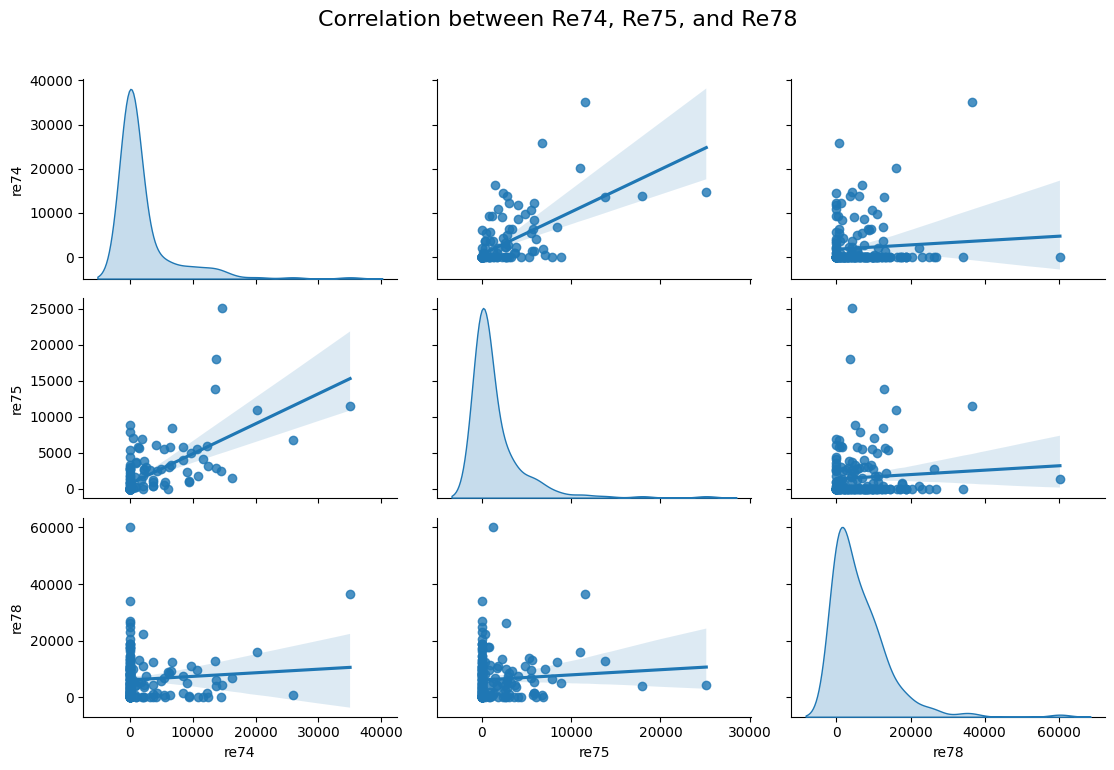

In [22]:
df_corr = treated[['re74', 're75', 're78']]

# Pairplot with specific pairings
plt.figure(figsize=(15, 2))
g = sns.pairplot(df_corr, kind='reg', diag_kind='kde', height=2.5, aspect=1.5)
g.fig.suptitle("Correlation between Re74, Re75, and Re78", y=1.02, fontsize=16)
# plt.title("Eraning between years before and after treatment")
plt.tight_layout()

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [66]:
treated.columns

Index(['id', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

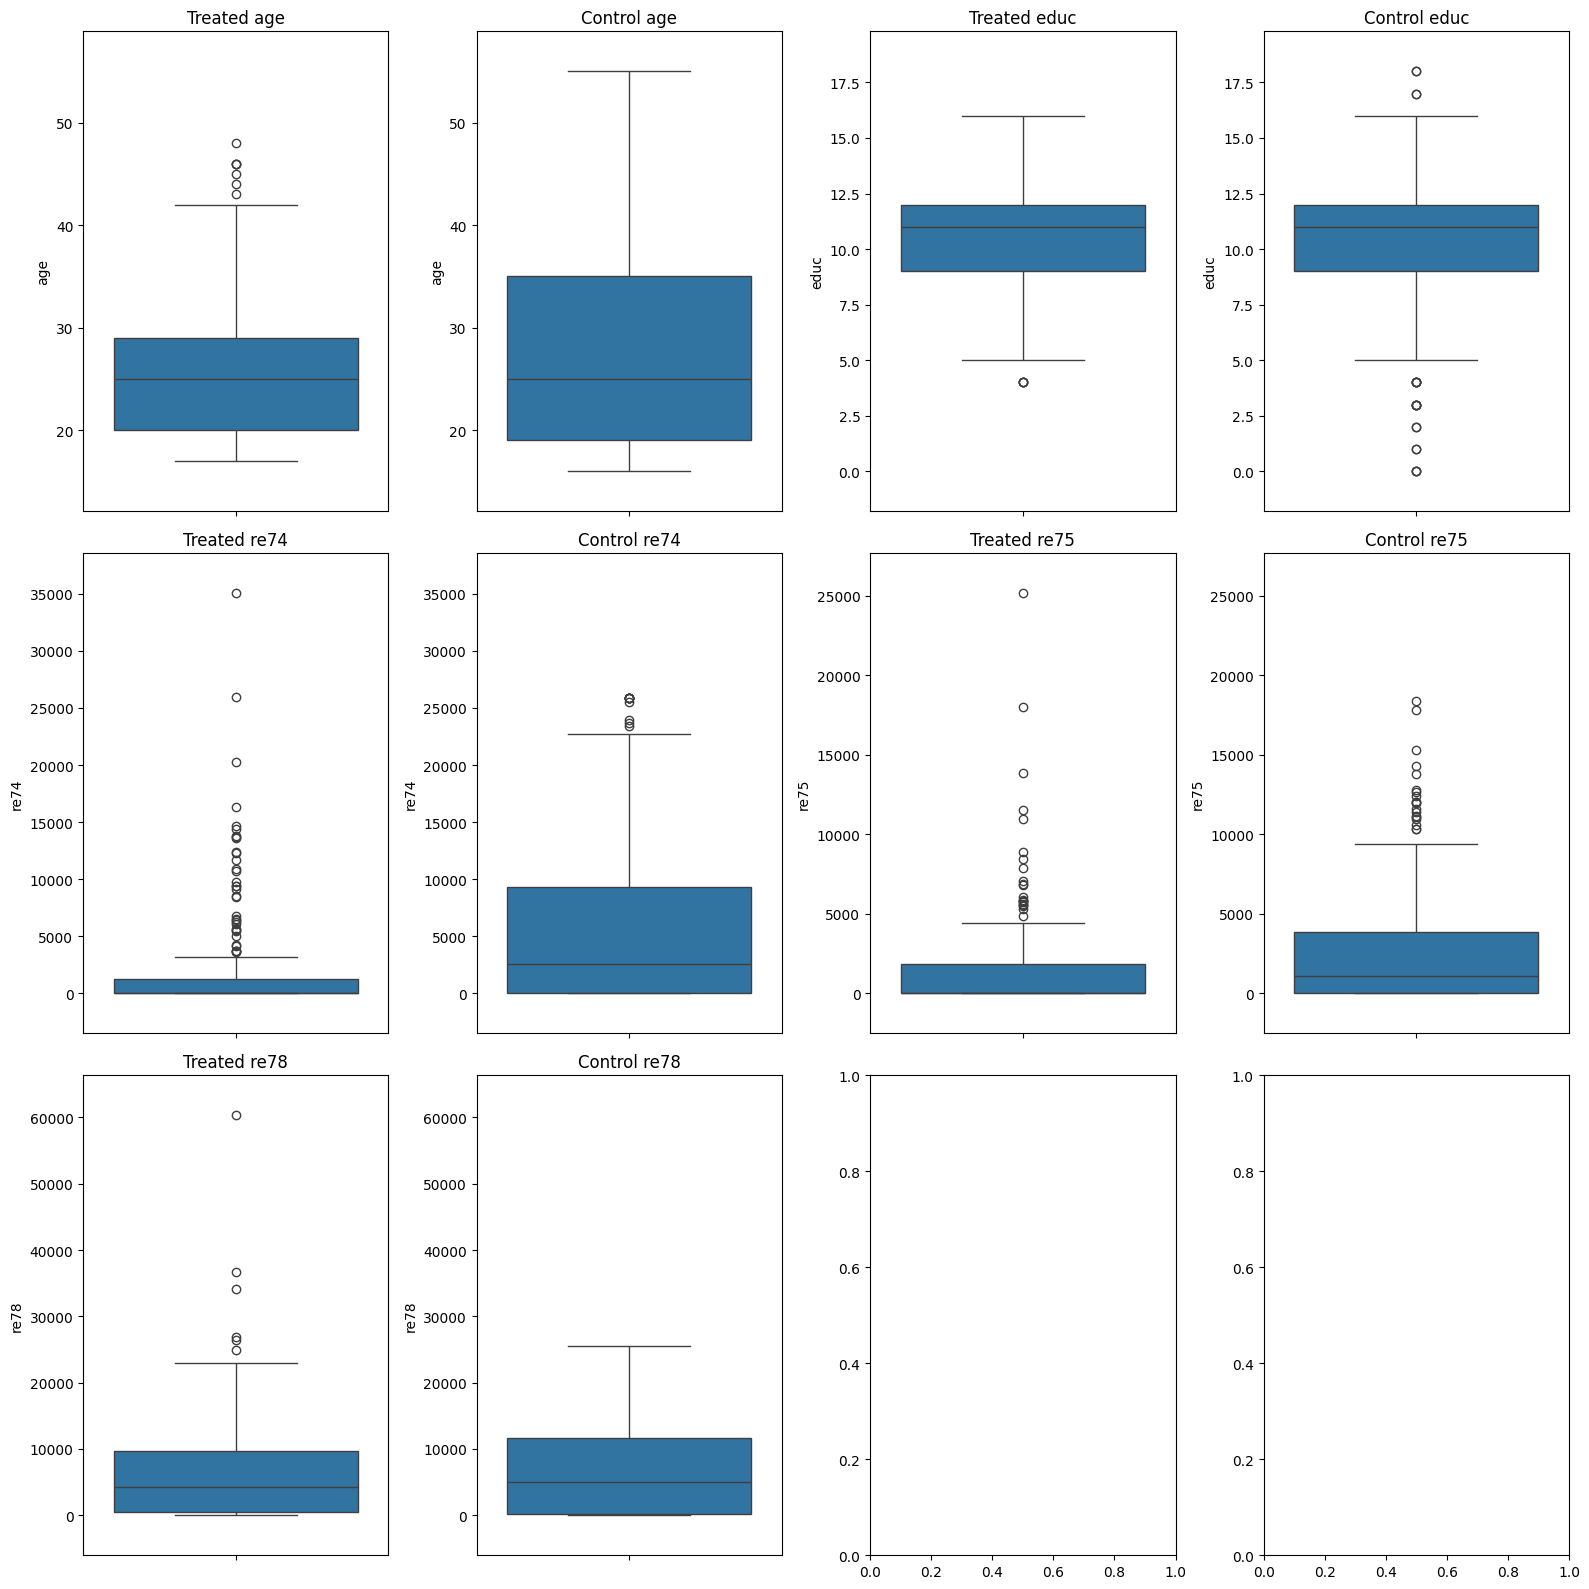

In [55]:
''' your code and explanations '''

features = ['age', 'educ', 're74', 're75', 're78']

fig, ax = plt.subplots(len(features)//2 + 1, 4, figsize=(16, 16))

for i, feature in enumerate(features):
    sns.boxplot(y=feature, data=treated, ax=ax[i//2][(i*2 + 0)%4])
    ax[i//2][(i*2 + 0)%4].set_title(f'Treated {feature}')

    sns.boxplot(y=feature, data=control, ax=ax[i//2][(i*2 + 1)%4])
    ax[i//2][(i*2 + 1)%4].set_title(f'Control {feature}')

    # Set the same y-axis range
    y_min = min(treated[feature].min(), control[feature].min())
    y_max = max(treated[feature].max(), control[feature].max())

    # Add a small margin (5% of the range) for better visibility
    margin = (y_max - y_min) * 0.1
    for axis in ax:
        ax[i//2][(i*2 + 0)%4].set_ylim(y_min - margin, y_max + margin)
        ax[i//2][(i*2 + 1)%4].set_ylim(y_min - margin, y_max + margin)

plt.tight_layout()
plt.show()

treated_marriage_1 = 0.1891891891891892
treated_marriage_0 = 0.8108108108108109
control_marriage_1 = 0.5128205128205128
control_marriage_0 = 0.48717948717948717
treated_marriage_1 + treated_marriage_0 = 1.0
control_marriage_1 + control_marriage_0 = 1.0


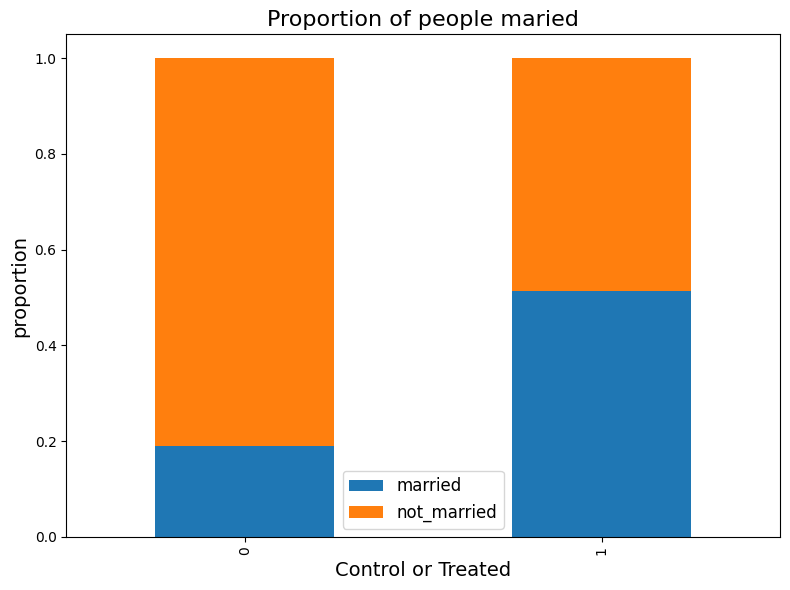

In [86]:
treated_n = len(treated)
treated_marriage_1 = len(treated[treated["married"] == 1]) / treated_n
treated_marriage_0 = len(treated[treated["married"] == 0]) / treated_n

control_n = len(control)
control_marriage_1 = len(control[control["married"] == 1]) / control_n
control_marriage_0 = len(control[control["married"] == 0]) / control_n

print(f"{treated_marriage_1 = }")
print(f"{treated_marriage_0 = }")
print(f"{control_marriage_1 = }")
print(f"{control_marriage_0 = }")
print(f"{treated_marriage_1 + treated_marriage_0 = }")
print(f"{control_marriage_1 + control_marriage_0 = }")

plot_df = {
    "married": [treated_marriage_1, control_marriage_1],
    "not_married": [treated_marriage_0, control_marriage_0],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=True, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people maried", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

treated_race_0 = 0.15675675675675677
treated_race_1 = 0.8432432432432433
treated_race_h = 0.05945945945945946
control_race_0 = 0.7972027972027972
control_race_1 = 0.20279720279720279
control_race_h = 0.14219114219114218
treated = 1.0594594594594595
control = 1.1421911421911422


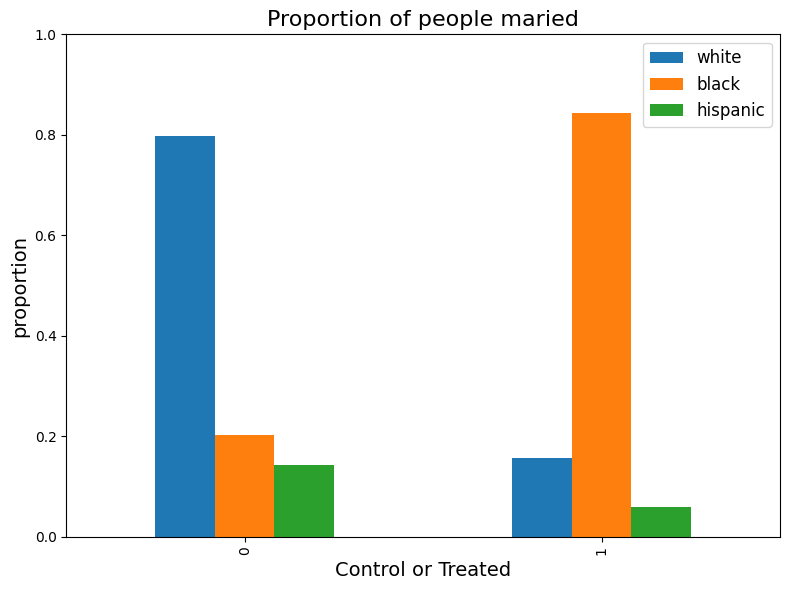

In [ ]:
treated_n = len(treated)
treated_race_0 = len(treated[treated["black"] == 0]) / treated_n
treated_race_1 = len(treated[treated["black"] == 1]) / treated_n
treated_race_h = len(treated[treated["hispan"] == 1]) / treated_n

control_n = len(control)
control_race_0 = len(control[control["black"] == 0]) / control_n
control_race_1 = len(control[control["black"] == 1]) / control_n
control_race_h = len(control[control["hispan"] == 1]) / control_n


print(f"{treated_race_0 = }")
print(f"{treated_race_1 = }")
print(f"{treated_race_h = }")
print(f"{control_race_0 = }")
print(f"{control_race_1 = }")
print(f"{control_race_h = }")
print(f"treated = {treated_race_0 + treated_race_1 + treated_race_h}")
print(f"control = {control_race_0 + control_race_1 + control_race_h}")

plot_df = {
    "white": [control_race_0, treated_race_0],
    "black": [control_race_1, treated_race_1],
    "hispanic": [control_race_h, treated_race_h],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=False, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people race", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)
plt.ylim(0,1)

# Afficher le graphique
plt.tight_layout()
plt.show()

treated_degree_1 = 0.7081081081081081
treated_degree_0 = 0.2918918918918919
control_degree_1 = 0.5967365967365967
control_degree_0 = 0.40326340326340326
treated_degree_1 + treated_degree_0 = 1.0
control_degree_1 + control_degree_0 = 1.0


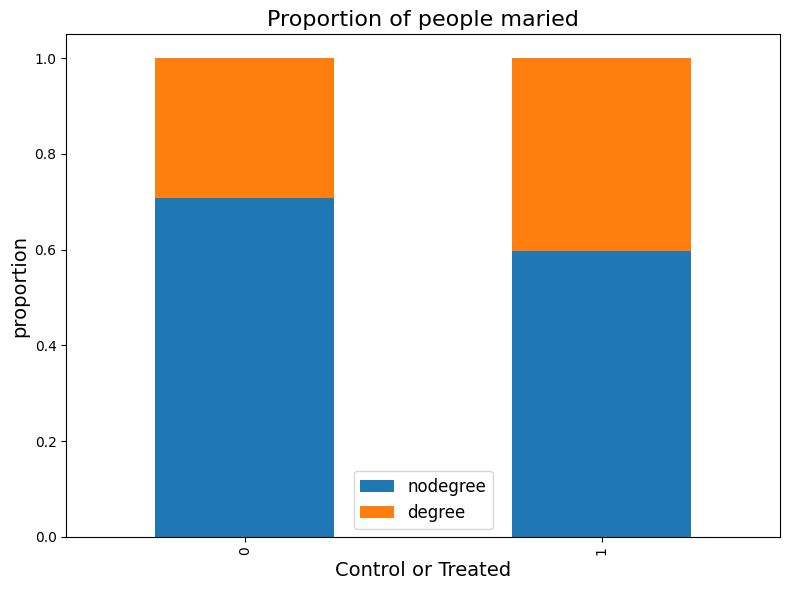

In [93]:
treated_n = len(treated)
treated_degree_1 = len(treated[treated["nodegree"] == 1]) / treated_n
treated_degree_0 = len(treated[treated["nodegree"] == 0]) / treated_n

control_n = len(control)
control_degree_1 = len(control[control["nodegree"] == 1]) / control_n
control_degree_0 = len(control[control["nodegree"] == 0]) / control_n

print(f"{treated_degree_1 = }")
print(f"{treated_degree_0 = }")
print(f"{control_degree_1 = }")
print(f"{control_degree_0 = }")
print(f"{treated_degree_1 + treated_degree_0 = }")
print(f"{control_degree_1 + control_degree_0 = }")

plot_df = {
    "nodegree": [treated_degree_1, control_degree_1],
    "degree": [treated_degree_0, control_degree_0],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=True, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people without a degree", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [105]:
''' your code and explanations ''';
def standarize_column(names: list[str], df: pd.DataFrame):
    for name in names:
        df[name] = (df[name] - df[name].mean())/df[name].std()
        
standarize_column(["age", "educ", "re74", "re75"], df)

mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan) + \
                        C(married) + C(nodegree) + re74 + \
                        re75', data=df)
res = mod.fit()

df["propensity_score"] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                  0.3508
Time:                        14:25:35   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

- We can say that being balck or white has a lot of importance to say if the patient was treated or not
- Age or the income in 1975 have less importance

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.

    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
  
Optimal matching is then found with:

    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [113]:
def get_similarity(p_1, p_2):
    return 1-np.abs(p_1 - p_2)

treated = df[df["treat"] == 1]
control = df[df["treat"] == 0]
control

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
185,PSID1,0,0.266851,0.658697,0,0,1,0,2.409582,4.904085,25564.6700,0.026118
186,PSID2,0,-0.137958,0.658697,0,0,1,0,3.288807,4.740028,25564.6700,0.015993
187,PSID3,0,-0.239161,2.180579,0,0,1,0,3.288807,3.984390,25564.6700,0.026004
188,PSID4,0,1.481280,0.278227,0,0,1,1,2.659709,3.665512,15491.0100,0.038500
189,PSID5,0,-0.239161,-0.482714,1,0,1,1,1.585705,3.517209,0.0000,0.432900
...,...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,10150.5000,0.123144
610,PSID426,0,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,19464.6100,0.034560
611,PSID427,0,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0.0000,0.183351
612,PSID428,0,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,187.6713,0.383032


In [ ]:
''' your code and explanations '''

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(
            control_row['propensity_score'], treatment_row['propensity_score']
        )

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_df = df.iloc[matched]

balanced_df

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
54,NSW55,1,0.266851,0.278227,1,0,1,1,-0.703546,-0.662971,590.7818,0.612917
156,NSW157,1,-0.947578,-0.482714,1,0,0,1,-0.703546,0.334510,5010.3420,0.722212
519,PSID335,0,-0.846375,0.658697,1,0,0,0,-0.444043,-0.662971,0.0000,0.610997
440,PSID256,0,-1.048780,-0.863185,1,0,0,1,-0.703546,-0.526076,0.0000,0.651762
56,NSW57,1,0.975268,-0.482714,1,0,0,1,-0.703546,-0.662971,1067.5060,0.746405
...,...,...,...,...,...,...,...,...,...,...,...,...
51,NSW52,1,0.368054,0.278227,1,0,1,1,-0.703546,-0.662971,8087.4870,0.616653
211,PSID27,0,0.874066,-0.482714,1,0,1,1,1.342837,1.903264,0.0000,0.433438
40,NSW41,1,-0.643970,0.658697,1,0,0,0,-0.703546,-0.662971,1254.5820,0.646507
593,PSID409,0,-1.048780,-0.102244,0,0,0,1,-0.703546,-0.662971,14942.7700,0.105262


In [120]:
control = balanced_df[balanced_df["treat"] == 0]
treated = balanced_df[balanced_df["treat"] == 1]
print(len(treated))
len(control) == len(treated)

185


True

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [119]:
balanced_df.columns

Index(['id', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78', 'propensity_score'],
      dtype='object')

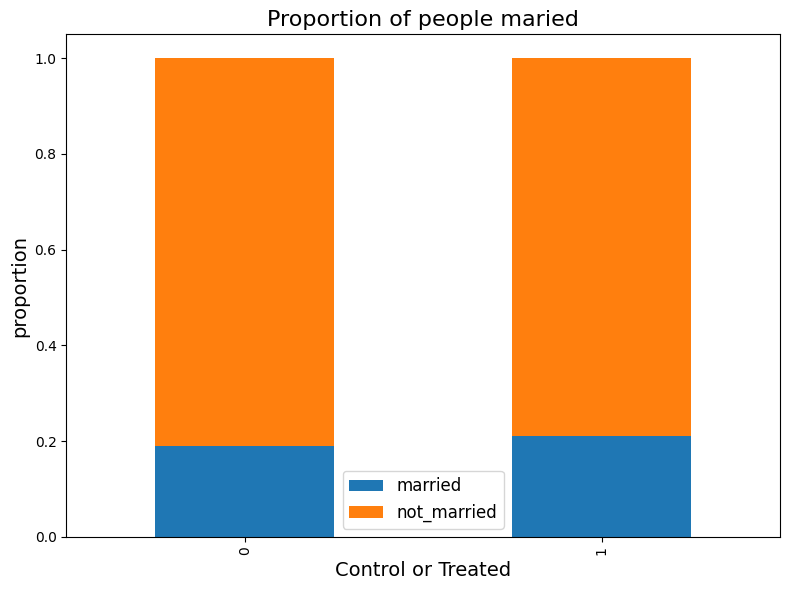

In [122]:
''' your code and explanations '''
treated_n = len(treated)
treated_marriage_1 = len(treated[treated["married"] == 1]) / treated_n
treated_marriage_0 = len(treated[treated["married"] == 0]) / treated_n

control_n = len(control)
control_marriage_1 = len(control[control["married"] == 1]) / control_n
control_marriage_0 = len(control[control["married"] == 0]) / control_n

plot_df = {
    "married": [treated_marriage_1, control_marriage_1],
    "not_married": [treated_marriage_0, control_marriage_0],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=True, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people maried", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

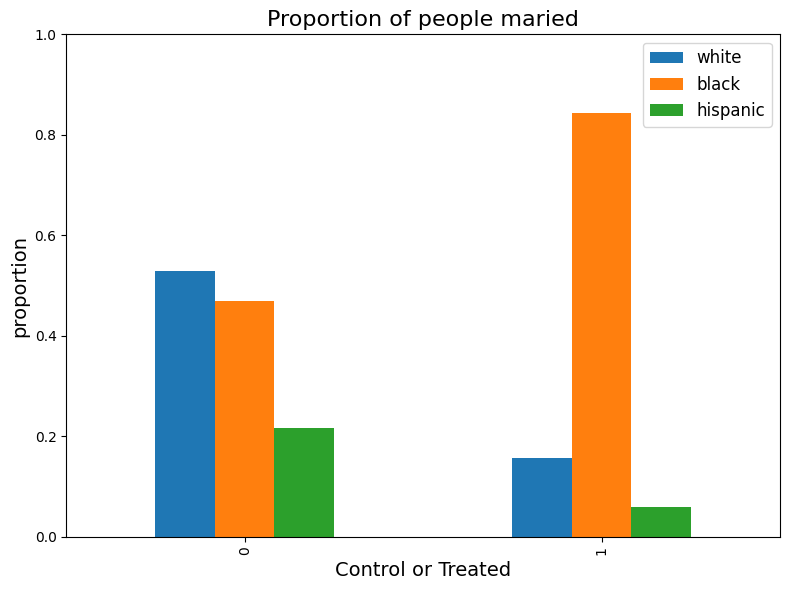

In [123]:
treated_n = len(treated)
treated_race_0 = len(treated[treated["black"] == 0]) / treated_n
treated_race_1 = len(treated[treated["black"] == 1]) / treated_n
treated_race_h = len(treated[treated["hispan"] == 1]) / treated_n

control_n = len(control)
control_race_0 = len(control[control["black"] == 0]) / control_n
control_race_1 = len(control[control["black"] == 1]) / control_n
control_race_h = len(control[control["hispan"] == 1]) / control_n


plot_df = {
    "white": [control_race_0, treated_race_0],
    "black": [control_race_1, treated_race_1],
    "hispanic": [control_race_h, treated_race_h],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=False, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people race", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)
plt.ylim(0,1)

# Afficher le graphique
plt.tight_layout()
plt.show()

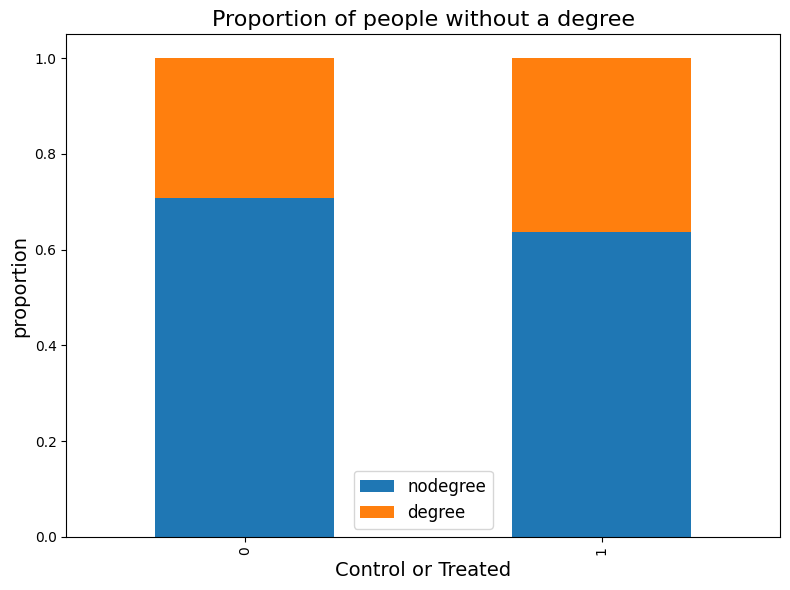

In [124]:
treated_n = len(treated)
treated_degree_1 = len(treated[treated["nodegree"] == 1]) / treated_n
treated_degree_0 = len(treated[treated["nodegree"] == 0]) / treated_n

control_n = len(control)
control_degree_1 = len(control[control["nodegree"] == 1]) / control_n
control_degree_0 = len(control[control["nodegree"] == 0]) / control_n

plot_df = {
    "nodegree": [treated_degree_1, control_degree_1],
    "degree": [treated_degree_0, control_degree_0],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=True, figsize=(8, 6))
# Ajouter des titres et labels
plt.title("Proportion of people without a degree", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

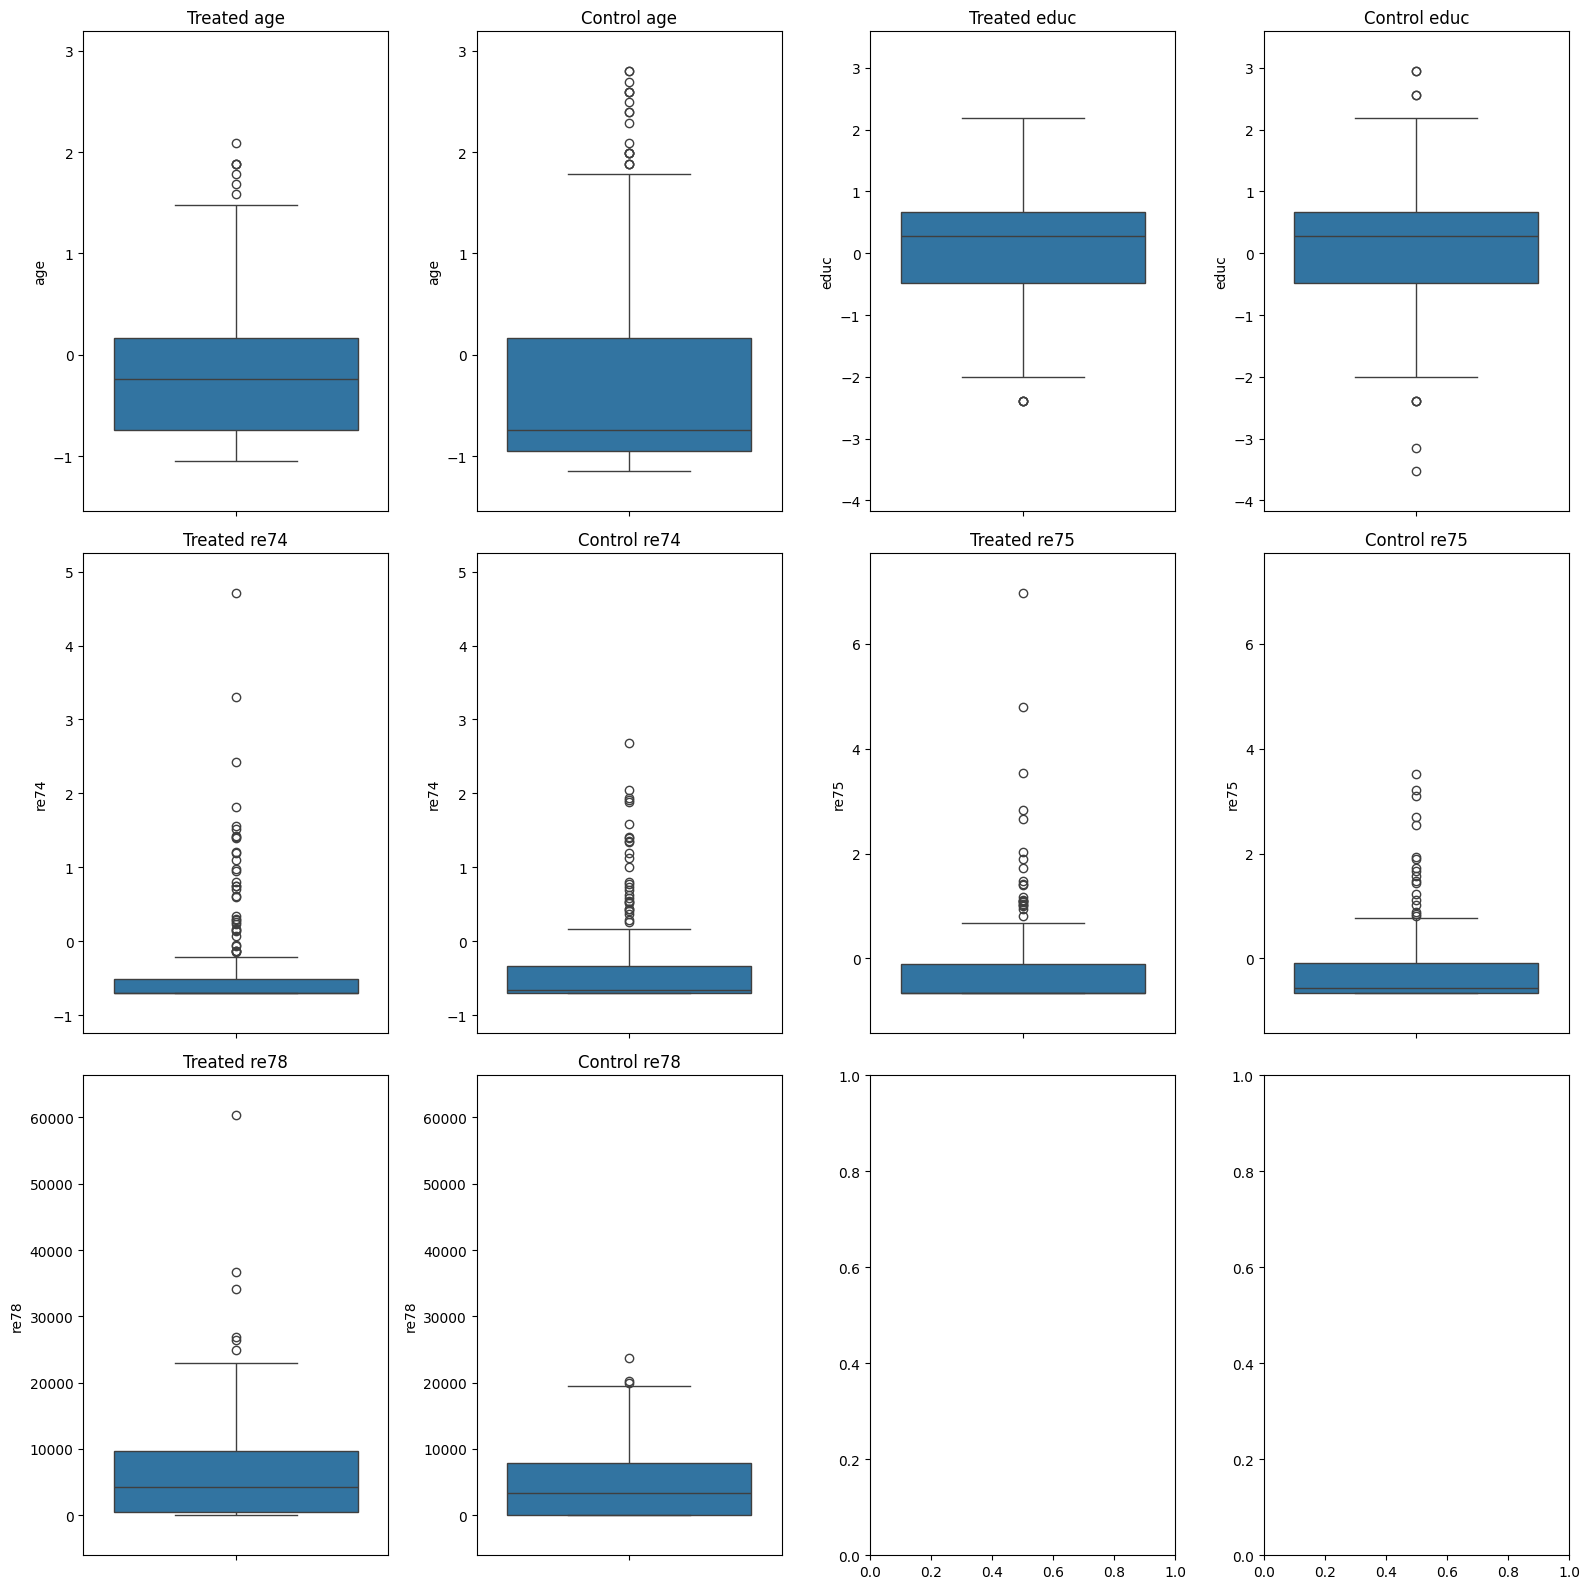

In [125]:
features = ['age', 'educ', 're74', 're75', 're78']

fig, ax = plt.subplots(len(features)//2 + 1, 4, figsize=(16, 16))

for i, feature in enumerate(features):
    sns.boxplot(y=feature, data=treated, ax=ax[i//2][(i*2 + 0)%4])
    ax[i//2][(i*2 + 0)%4].set_title(f'Treated {feature}')

    sns.boxplot(y=feature, data=control, ax=ax[i//2][(i*2 + 1)%4])
    ax[i//2][(i*2 + 1)%4].set_title(f'Control {feature}')

    # Set the same y-axis range
    y_min = min(treated[feature].min(), control[feature].min())
    y_max = max(treated[feature].max(), control[feature].max())

    # Add a small margin (5% of the range) for better visibility
    margin = (y_max - y_min) * 0.1
    for axis in ax:
        ax[i//2][(i*2 + 0)%4].set_ylim(y_min - margin, y_max + margin)
        ax[i//2][(i*2 + 1)%4].set_ylim(y_min - margin, y_max + margin)

plt.tight_layout()
plt.show()

### As we cansee all the featires are balanced within a certain margin but the race

In [126]:
control.columns

Index(['id', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78', 'propensity_score'],
      dtype='object')

In [127]:
''' your code and explanations '''
def get_similarity(control_row, treatment_row):
    return(
        1
        - np.abs(control_row["propensity_score"] - treatment_row["propensity_score"])
        - int(control_row["black"]  !=  treatment_row["black"])
        - int(control_row["hispan"]  !=  treatment_row["hispan"])
    )


# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(
            control_row, treatment_row
        )

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_df = df.iloc[matched]

balanced_df

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
14,NSW15,1,-1.048780,-1.243655,1,0,0,1,-0.703546,-0.662971,3023.879,0.608586
576,PSID392,0,-1.048780,-0.102244,1,0,0,1,-0.703546,-0.662971,0.000,0.716120
1,NSW2,1,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,3595.894,0.224634
145,NSW146,1,-0.846375,0.278227,1,0,0,1,-0.347720,0.130576,4146.603,0.748849
120,NSW121,1,0.165649,1.419638,1,0,0,0,-0.703546,-0.456739,17814.980,0.748170
...,...,...,...,...,...,...,...,...,...,...,...,...
391,PSID207,0,1.278875,0.658697,0,1,0,0,1.128400,-0.300091,3873.121,0.122806
268,PSID84,0,0.975268,0.278227,0,1,0,1,-0.608576,0.767363,0.000,0.384189
217,PSID33,0,-0.036756,0.658697,0,0,1,0,1.190705,1.676192,7806.829,0.024896
281,PSID97,0,-0.340363,0.658697,1,0,1,0,0.619980,0.639703,0.000,0.361929


In [130]:
control = balanced_df[balanced_df["treat"] == 0]
treated = balanced_df[balanced_df["treat"] == 1]
print(len(treated))
len(control) == len(treated)

116


True

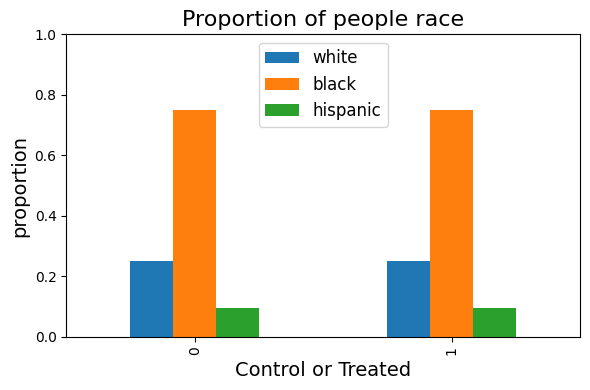

In [132]:
treated_n = len(treated)
treated_race_0 = len(treated[treated["black"] == 0]) / treated_n
treated_race_1 = len(treated[treated["black"] == 1]) / treated_n
treated_race_h = len(treated[treated["hispan"] == 1]) / treated_n

control_n = len(control)
control_race_0 = len(control[control["black"] == 0]) / control_n
control_race_1 = len(control[control["black"] == 1]) / control_n
control_race_h = len(control[control["hispan"] == 1]) / control_n


plot_df = {
    "white": [control_race_0, treated_race_0],
    "black": [control_race_1, treated_race_1],
    "hispanic": [control_race_h, treated_race_h],
}
plot_df = pd.DataFrame(plot_df)

plot_df.plot(kind='bar', stacked=False, figsize=(6, 4))
# Ajouter des titres et labels
plt.title("Proportion of people race", fontsize=16)
plt.xlabel("Control or Treated", fontsize=14)
plt.ylabel("proportion", fontsize=14)
plt.legend(title="", fontsize=12)
plt.ylim(0,1)

# Afficher le graphique
plt.tight_layout()
plt.show()

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [133]:
''' your code and explanations '''
treated[['re74', 're75', 're78']].describe()

,re74,re75,re78
count,116.000000,116.000000,116.000000
mean,-0.274009,-0.133883,6305.529606
std,0.900678,1.138768,6670.109061
min,-0.703546,-0.662971,0.000000
25%,-0.703546,-0.662971,725.969275
50%,-0.703546,-0.662971,4648.736000
75%,-0.334934,-0.119069,10160.440000
max,4.705571,6.965879,36646.950000


In [134]:
control[['re74', 're75', 're78']].describe()


,re74,re75,re78
count,116.000000,116.000000,116.000000
mean,-0.231769,-0.078241,5286.872596
std,0.766090,0.904861,6131.704955
min,-0.703546,-0.662971,0.000000
25%,-0.703546,-0.662971,0.000000
50%,-0.606157,-0.523088,2366.579000
75%,-0.210400,0.209870,9072.502000
max,2.679974,3.517209,20243.380000


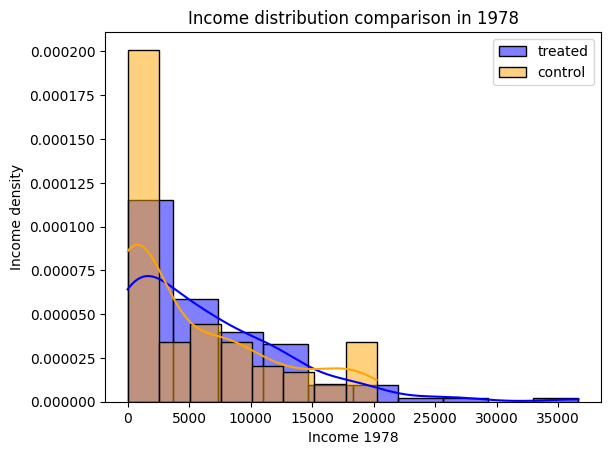

In [135]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

<Figure size 1500x200 with 0 Axes>

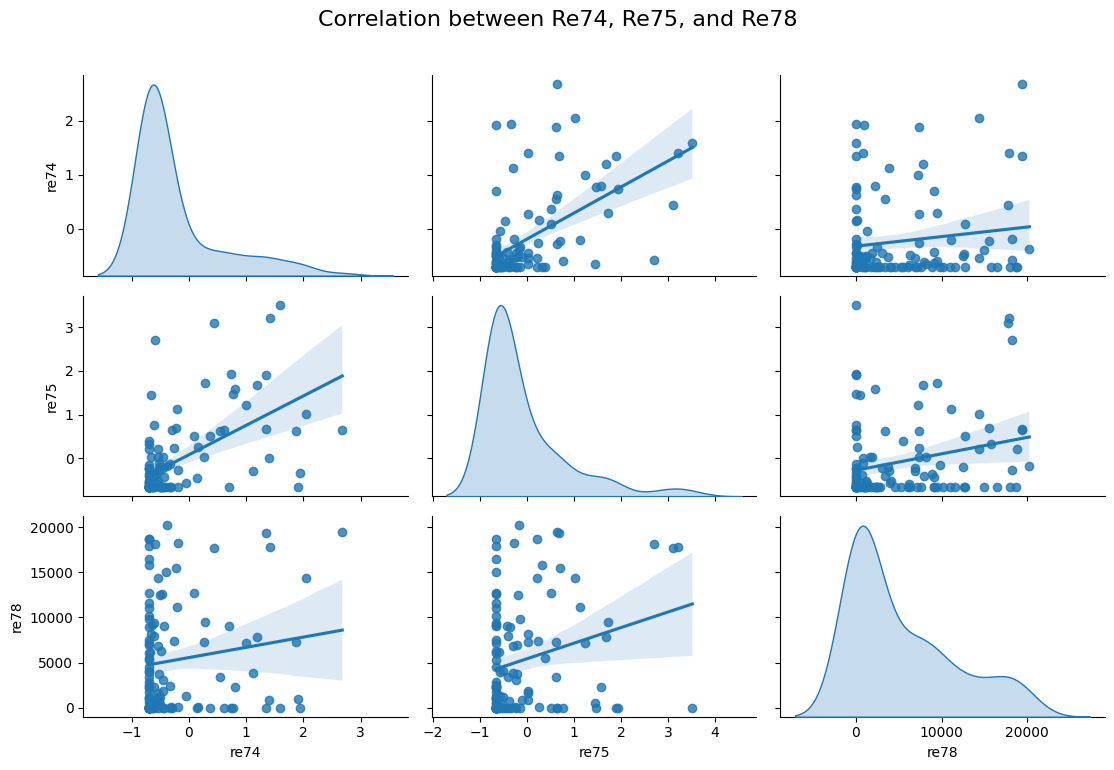

In [136]:
df_corr = control[['re74', 're75', 're78']]

# Pairplot with specific pairings
plt.figure(figsize=(15, 2))
g = sns.pairplot(df_corr, kind='reg', diag_kind='kde', height=2.5, aspect=1.5)
g.fig.suptitle("Correlation between Re74, Re75, and Re78", y=1.02, fontsize=16)
# plt.title("Eraning between years before and after treatment")
plt.tight_layout()